# Introduction to Python for Earth Scientists

These notebooks have been developed by Calum Chamberlain, Finnigan Illsley-Kemp and John Townend at [Victoria University of Wellington-Te Herenga Waka](https://www.wgtn.ac.nz) for use by Earth Science graduate students. 

The notebooks cover material that we think will be of particular benefit to those students with little or no previous experience of computer-based data analysis. We presume very little background in command-line or code-based computing, and have compiled this material with an emphasis on general tasks that a grad student might encounter on a daily basis. 

In 2021, this material will be delivered at the start of Trimester 1 in conjunction with [ESCI451 Active Earth](https://www.wgtn.ac.nz/courses/esci/451/2021/offering?crn=32176). Space and pandemic alert levels permitting, interested students not enrolled in ESCI451 are encouraged to come along too but please contact Calum, Finn, or John first.

| Notebook | Contents | Data |
| --- | --- | --- |
| [1A](ESCI451_Module_1A.ipynb) | Introduction to programming, Python, and Jupyter notebooks | - |
| [1B](ESCI451_Module_1B.ipynb) | Basic data types and variables, getting data, and plotting with Matplotlib | Geodetic positions |
| [2A](ESCI451_Module_2A.ipynb) | More complex plotting, introduction to Numpy | Geodetic positions; DFDP-2B temperatures |
| **[2B](ESCI451_Module_2B.ipynb)** | **Using Pandas to load, peruse and plot data** | **Earthquake catalogue**  |
| [3A](ESCI451_Module_3A.ipynb) | Working with Pandas dataframes | Geochemical data set; earthquake catalogue |
| [3B](ESCI451_Module_3B.ipynb) | Simple time series analysis using Pandas | Historical temperature records |
| [4A](ESCI451_Module_4A.ipynb) | Making maps with Cartopy | Earthquake catalogue |
| [4B](ESCI451_Module_4B.ipynb) | Working with gridded data | DEMs and Ashfall data |

The content may change in response to students' questions or current events. Each of the four modules has been designed to take about three hours, with a short break between each of the two parts.

# This notebook

1. An introduction to Pandas and dataframes
   - Loading data into a dataframe
   - Visualising the datafame
   - Dataframe statistics
   - Sorting and slicing a dataframe

# An introduction to Pandas and dataframes
 
<img alt="Pandas logo" align="right" style="width:30%" src="https://dev.pandas.io/static/img/pandas.svg">


So far we have looked at some fairly simple datasets.  NumPy is great for multi-dimensional arrays, but
book-keeping can be tricky and somewhat counterintuitive.  Pandas is our friend here.  Pandas adds meta-data to our data, and allows
us to interact with data using names and words, rather than indexes. This can mean that we can
write much clearer code (yay).  It's also really good at working with data that you would have previously
interacted with in spreadsheets.  Spreadsheets are the source of **many** errors, and keeping data and
results in the same file is almost criminal! Your data are sacred and should **never be in the same
file that you process them in!**.

Pandas [github README](https://github.com/pandas-dev/pandas/blob/master/README.md) outlines why you should
care about Pandas:

> **pandas** is a Python package providing fast, flexible, and expressive data structures designed to 
make working with "relational" or "labeled" data both easy and intuitive. It aims to be the 
fundamental high-level building block for doing practical, **real world** data analysis in Python.
Additionally, it has the broader goal of becoming the **most powerful and flexible open source 
data analysis / manipulation tool available in any language**. It is already well on its way towards 
this goal.

When Pandas says **real world** think messy data. Measurements of properties of the Earth are *almost always*
messy: data are missed when power fails or equipment breaks or when it is too wet to get into the field,
almost all Earth science datasets are noisy, and almost all Earth science data are multi-dimensional and
relational (e.g. multiple variables at one particular place and/or time).  Pandas is really good at coping
with this mess, and **will make your life easier!**

In [1]:
# %matplotlib widget

## Loading data into a dataframe

To explore some of the functionality of Pandas, we need a dataset. One large and freely accesible
geoscience dataset in New Zealand is the GeoNet eatrhquake catalogue. This contains hundreds of thousands
of earthquakes, so should be fun to play around with.

To start off with, we need to get the data.  We could manually query the 
[Quake Search](https://quakesearch.geonet.org.nz/) web-app, but that means we need to
click lots of buttons, and isn't great for just exploring a dataset.  Lets do it
programatically.  We will build a function, but let's look at the steps along the way.

### Building a query

The Quake Search page can be queried by generating a specific web request in the form:

`"https://quakesearch.geonet.org.nz/csv?bbox={min-longitude},{min-latitude},{max-longitude},{max-latitude}&minmag={min-magnitude}&maxmag={max-magnitude}&mindepth={min-depth}&maxdepth={max-depth}&startdate={start-time}&enddate={end-time}"`

We can build that as a string really easily using variables in place of the curly-brackets things:

In [2]:
format_string = (
    "https://quakesearch.geonet.org.nz/csv?bbox="
    "{min_longitude},{min_latitude},{max_longitude},"
    "{max_latitude}&minmag={min_magnitude}"
    "&maxmag={max_magnitude}&mindepth={min_depth}"
    "&maxdepth={max_depth}&startdate={start_time}"
    "&enddate={end_time}")

min_latitude = -49.0
max_latitude = -40.0
min_longitude = 164.0
max_longitude = 182.0
min_magnitude = 0.0
max_magnitude = 9.0
min_depth = 0.0  # in km
max_depth = 500.0
start_time = "2019-1-1T00:00:00"
end_time = "2020-1-1T00:00:00"

query_string = format_string.format(
    min_latitude=min_latitude,
    max_latitude=max_latitude,
    min_longitude=min_longitude,
    max_longitude=max_longitude,
    min_magnitude=min_magnitude,
    max_magnitude=max_magnitude,
    min_depth=min_depth,
    max_depth=max_depth,
    start_time=start_time,
    end_time=end_time)

print(query_string)

https://quakesearch.geonet.org.nz/csv?bbox=164.0,-49.0,182.0,-40.0&minmag=0.0&maxmag=9.0&mindepth=0.0&maxdepth=500.0&startdate=2019-1-1T00:00:00&enddate=2020-1-1T00:00:00


See what we did? We specified the format of the query string, then specified the particular search criteria we were interested int, and then put those two elements together to construct the query string. Because we have used variables in place
of parts of the string, we can change our query really eaisly.  

If you click that link we just constructed you should download a file called *earthquakes.csv*. What we really want though is to download that file and look at it in Python straight away.  To do that
we can use the `requests` package to make a web-request:

In [3]:
import requests

response = requests.get(query_string)
print(response)

<Response [200]>


All being well, that should have output `<Response [200]>`. The value of 200 is simply a return code saying that things went as planned.

The `Response` object contains the content that we requested from the web as a `.contents` attribute.  Lets have a look at the first 1000 elements of the response:

In [4]:
print(response.content[0:1000])

b'publicid,eventtype,origintime,modificationtime,longitude,latitude,magnitude,depth,magnitudetype,depthtype,evaluationmethod,evaluationstatus,evaluationmode,earthmodel,usedphasecount,usedstationcount,magnitudestationcount,minimumdistance,azimuthalgap,originerror,magnitudeuncertainty\n2019p986237,earthquake,2019-12-31T21:47:06.740Z,2019-12-31T21:49:52.658Z,174.1030579,-41.51368713,1.887827327,24.54598236,M,,LOCSAT,confirmed,manual,iasp91,29,16,5,0.1469085962,91.27532959,0.5454116871,0\n2019p986148,earthquake,2019-12-31T21:00:11.122Z,2019-12-31T21:04:12.241Z,173.2087708,-41.58277893,1.539235603,5.996267319,M,,LOCSAT,confirmed,manual,iasp91,15,10,5,0.2897528708,67.96588135,0.4020879339,0\n2019p986043,earthquake,2019-12-31T20:03:47.465Z,2019-12-31T20:06:20.365Z,176.4427795,-40.39003754,1.668549025,12.87530804,M,,LOCSAT,confirmed,manual,iasp91,26,17,7,0.0738600567,110.4887924,0.5038800067,0\n2019p985959,earthquake,2019-12-31T19:19:04.555Z,2019-12-31T19:21:40.157Z,176.4387512,-40.38579559,2.

This is the contents of the `earthquakes.csv` file and we can write it to a file in the data directory.  The
contents that we have downloaded are in binary (which `print` converted a string before
displaying it), so we have to open the file we want to write to using the `wb` argument, which means
"open the file in binary mode with write permission":

In [5]:
with open("data/earthquakes.csv", "wb") as f:
    f.write(response.content)

Now we could read those data in using some convoluted looping and NumPy arrays, or we could
just get Pandas to read it using the 
[pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)
function.  This will quickly parse that large csv file into a Pandas 
[dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html):

In [6]:
import pandas as pd  # It is a normal convention to rename pandas as pd for short

earthquakes = pd.read_csv("data/earthquakes.csv")

print(earthquakes[0:5])

      publicid   eventtype                origintime  \
0  2019p986237  earthquake  2019-12-31T21:47:06.740Z   
1  2019p986148  earthquake  2019-12-31T21:00:11.122Z   
2  2019p986043  earthquake  2019-12-31T20:03:47.465Z   
3  2019p985959  earthquake  2019-12-31T19:19:04.555Z   
4  2019p985713  earthquake  2019-12-31T17:08:01.114Z   

           modificationtime   longitude   latitude  magnitude      depth  \
0  2019-12-31T21:49:52.658Z  174.103058 -41.513687   1.887827  24.545982   
1  2019-12-31T21:04:12.241Z  173.208771 -41.582779   1.539236   5.996267   
2  2019-12-31T20:06:20.365Z  176.442780 -40.390038   1.668549  12.875308   
3  2019-12-31T19:21:40.157Z  176.438751 -40.385796   2.371542  10.608765   
4  2019-12-31T17:22:49.180Z  171.080139 -43.063313   1.901220   5.000000   

  magnitudetype          depthtype  ... evaluationstatus evaluationmode  \
0             M                NaN  ...        confirmed         manual   
1             M                NaN  ...        confirmed

Dataframes are really handy ways of handling "spreadshseet"-type data, because they provide a convenient way of labelling the columns. Here we have printed out the first five rows (starting from zero, remember) of the `earthquakes` dataframe we have create. This shows the catalogue information for five earthquakes, arranged in columns labelled `publicid`, `eventtype`, `origintime`, etc. You can see a full list of the column names with the following command:

In [7]:
earthquakes.columns

Index(['publicid', 'eventtype', 'origintime', 'modificationtime', 'longitude',
       'latitude', 'magnitude', 'depth', 'magnitudetype', 'depthtype',
       'evaluationmethod', 'evaluationstatus', 'evaluationmode', 'earthmodel',
       'usedphasecount', 'usedstationcount', 'magnitudestationcount',
       'minimumdistance', 'azimuthalgap', 'originerror',
       'magnitudeuncertainty'],
      dtype='object')

We can access the contents of those columns pretty easily too:

In [8]:
print(earthquakes["origintime"][0:10])

0    2019-12-31T21:47:06.740Z
1    2019-12-31T21:00:11.122Z
2    2019-12-31T20:03:47.465Z
3    2019-12-31T19:19:04.555Z
4    2019-12-31T17:08:01.114Z
5    2019-12-31T16:05:50.502Z
6    2019-12-31T15:47:20.933Z
7    2019-12-31T14:44:43.788Z
8    2019-12-31T14:43:39.777Z
9    2019-12-31T12:37:31.133Z
Name: origintime, dtype: object


See how in this case we've specified both a column (`origintime`) and a number of rows (the first ten).

Each column is a Pandas [Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html#pandas.Series) which is similar to a numpy array
and has a lot of the same functionality.

You will note that the time columns (`origintime` and `modificationtime`) have not been
read in ("parsed") in the most helpful way: we can see what the strings represent but can't yet treat them as dates or times directly. To get around this, we can tell pandas to read those columns in as `datetime` objects
using the `parse_dates` argument.  While we're at it, we can also get rid of the warning about values in column
0 having multiple dtypes by setting the `dtype` argument for the `publicid` column.

In [9]:
earthquakes = pd.read_csv(
    "data/earthquakes.csv",
    parse_dates=["origintime", "modificationtime"],
    dtype={"publicid": str})

print(earthquakes["origintime"][0:10])

0   2019-12-31 21:47:06.740000+00:00
1   2019-12-31 21:00:11.122000+00:00
2   2019-12-31 20:03:47.465000+00:00
3   2019-12-31 19:19:04.555000+00:00
4   2019-12-31 17:08:01.114000+00:00
5   2019-12-31 16:05:50.502000+00:00
6   2019-12-31 15:47:20.933000+00:00
7   2019-12-31 14:44:43.788000+00:00
8   2019-12-31 14:43:39.777000+00:00
9   2019-12-31 12:37:31.133000+00:00
Name: origintime, dtype: datetime64[ns, UTC]


Now the `dtype` of the `origintime` column is reported as `datetime64`, which is a 64-bit precision
`datetime` number. We'll leave more detailed discussion of dates and times until the next module and for the time being we'll explore the dataframe itself in a bit more detail. 

Before we do that, however, let's quickly address one other minor formatting issue. You might notice that some of the column names have a leading space
in them.  GeoNet doesn't format it's tables particularly nicely, and those leading spaces
are annoying. Let's rename the ` latitude`, ` magnitude` and ` depth` columns without
those superfluous spaces.

In [10]:
earthquakes = earthquakes.rename(
    columns={" magnitude": "magnitude",
             " latitude": "latitude",
             " depth": "depth"})

## Data visualisation

Now we have a nicely named dataframe, lets have a look at some of the data.
First lets look at magnitude against time. We could use matplotlib directly, but pandas
has some handy plotting shortcuts built in:

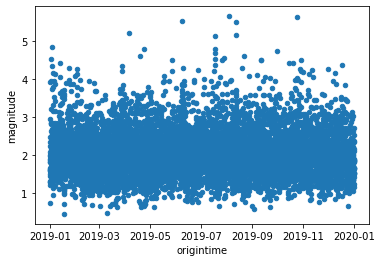

In [11]:
import matplotlib.pyplot as plt
earthquakes.plot(x="origintime", y="magnitude", kind="scatter")
plt.show()

Here we specified the `x` argument as the column name we wanted to plot on the x-axis, and
`y` as the other column name.  Pandas has a few different plotting options that can
be specified by the `kind` argument, you can find out more about them 
[here](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html).

You can clearly see the large magnitude Kaikoura earthquake standing out from everything else.

Another helpful plot might be a histogram. The syntax for that is pretty straightforward too and here are two examples:

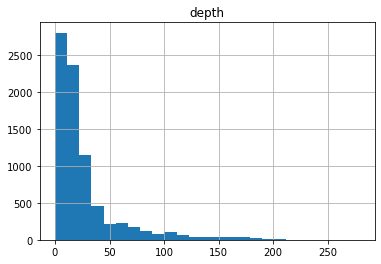

In [12]:
earthquakes.hist(column='depth', bins=25)
plt.show()

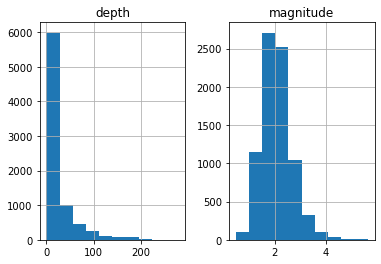

In [13]:
earthquakes.hist(column=['depth', 'magnitude'])
plt.show()

### Exercise:

Pick a specific region based on latitude and longitude ([this website](http://bboxfinder.com/) is
really helpful for finding bounding boxes) and get a dataframe spanning a longer period of
time.  Plot the magnitude vs. time graph for that region.

In [14]:
# Your answer here.  Call your dataframe something different to `earthquakes`

## Dataframe statistics

We can also obtain some basic stats from our dataframe, like the median magnitude...

In [15]:
print(earthquakes["magnitude"].median())

2.023237548


... or the maximum depth:

In [16]:
print(earthquakes['depth'].max())

278.75


There are lots of other useful ways you can extract descriptive statistics from your dataframe, which are documented [here](https://pandas.pydata.org/pandas-docs/stable/reference/series.html#computations-descriptive-stats).

### Exercise:

What is the mean, maximum and minimum magnitude in our dataframe?

In [17]:
# Your answer here

## Sorting the dateframe

Something we often need to do is to sort a dataset based on the value of one parameter).

In [18]:
earthquakes.sort_values(by=["latitude"], ascending=False)

,publicid,eventtype,origintime,modificationtime,longitude,latitude,magnitude,depth,magnitudetype,depthtype,...,evaluationstatus,evaluationmode,earthmodel,usedphasecount,usedstationcount,magnitudestationcount,minimumdistance,azimuthalgap,originerror,magnitudeuncertainty
5623,2019p284688,earthquake,2019-04-16 08:01:55.378000+00:00,2019-04-16 08:11:01.345000+00:00,176.621139,-40.000336,1.497677,35.388756,M,NaN,...,confirmed,manual,iasp91,18,11,7,0.152641,78.319641,0.309052,0.0
7730,2019p036721,earthquake,2019-01-14 14:05:42.206000+00:00,2019-01-14 14:09:52.242000+00:00,176.415314,-40.000515,2.225029,29.730085,M,NaN,...,confirmed,manual,iasp91,17,9,7,0.066559,83.778803,0.403685,0.0
496,2019p916427,earthquake,2019-12-06 01:52:46.211000+00:00,2019-12-06 01:56:23.717000+00:00,174.984024,-40.000664,2.044292,22.070503,M,NaN,...,confirmed,manual,iasp91,19,13,6,0.245721,135.217753,0.527270,0.0
1295,2019p802680,earthquake,2019-10-24 23:47:57.670000+00:00,2019-11-18 02:55:35.199000+00:00,174.560211,-40.000896,3.436356,20.674732,M,NaN,...,confirmed,manual,iasp91,33,22,17,0.409408,76.510666,0.537357,0.0
4821,2019p367590,earthquake,2019-05-17 00:12:26.541000+00:00,2019-05-17 00:19:37.865000+00:00,176.556595,-40.001907,2.163246,29.865091,M,NaN,...,confirmed,manual,iasp91,27,17,12,0.108698,70.106209,0.547902,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3437,2019p533779,earthquake,2019-07-17 11:57:11.369000+00:00,2019-08-12 02:27:26.615000+00:00,164.880844,-48.649693,4.785922,33.000000,M,operator assigned,...,confirmed,manual,iasp91,28,17,8,2.769040,331.510658,1.258380,0.0
3436,2019p533795,earthquake,2019-07-17 12:05:36.701000+00:00,2019-08-12 02:34:44.937000+00:00,165.042999,-48.653122,4.680016,33.000000,M,operator assigned,...,confirmed,manual,iasp91,25,14,7,2.696741,329.271395,0.710719,0.0
3438,2019p533764,earthquake,2019-07-17 11:49:45.290000+00:00,2019-08-12 02:21:18.312000+00:00,164.927567,-48.673595,4.528463,33.000000,M,operator assigned,...,confirmed,manual,iasp91,23,15,9,2.767939,331.347172,1.007652,0.0
3166,2019p564967,earthquake,2019-07-29 00:54:19.833000+00:00,2019-08-19 23:43:21.615000+00:00,164.858627,-48.690235,4.560219,33.000000,M,operator assigned,...,confirmed,manual,iasp91,20,11,7,2.811897,331.824367,1.216119,0.0


### Exercise:

Sort the dataframe by depth.

In [19]:
# Your answer here.

## Slicing dataframe

We can also select subsets of our dataframe; this is commonly referred to as "slicing".  Say you had downloaded the whole catalogue
and realised that you only wanted events shallower than 20 km depth. The `.loc` command is used to slice the dataframe to only those rows meeting the specific criteria:

In [20]:
earthquakes.loc[earthquakes["depth"] <= 20.0]

,publicid,eventtype,origintime,modificationtime,longitude,latitude,magnitude,depth,magnitudetype,depthtype,...,evaluationstatus,evaluationmode,earthmodel,usedphasecount,usedstationcount,magnitudestationcount,minimumdistance,azimuthalgap,originerror,magnitudeuncertainty
1,2019p986148,earthquake,2019-12-31 21:00:11.122000+00:00,2019-12-31 21:04:12.241000+00:00,173.208771,-41.582779,1.539236,5.996267,M,NaN,...,confirmed,manual,iasp91,15,10,5,0.289753,67.965881,0.402088,0.0
2,2019p986043,earthquake,2019-12-31 20:03:47.465000+00:00,2019-12-31 20:06:20.365000+00:00,176.442780,-40.390038,1.668549,12.875308,M,NaN,...,confirmed,manual,iasp91,26,17,7,0.073860,110.488792,0.503880,0.0
3,2019p985959,earthquake,2019-12-31 19:19:04.555000+00:00,2019-12-31 19:21:40.157000+00:00,176.438751,-40.385796,2.371542,10.608765,M,NaN,...,confirmed,manual,iasp91,24,15,6,0.078895,101.663696,0.710030,0.0
4,2019p985713,earthquake,2019-12-31 17:08:01.114000+00:00,2019-12-31 17:22:49.180000+00:00,171.080139,-43.063313,1.901220,5.000000,M,operator assigned,...,confirmed,manual,iasp91,27,19,7,0.176311,105.367616,0.545000,0.0
10,2019p985141,earthquake,2019-12-31 12:03:17.293000+00:00,2019-12-31 12:05:17.430000+00:00,173.130280,-41.642826,1.522212,6.780022,M,NaN,...,confirmed,manual,iasp91,16,9,3,0.206633,75.948624,0.531287,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8008,2019p000831,earthquake,2019-01-01 07:22:47.364000+00:00,2019-01-01 07:27:48.201000+00:00,174.301102,-41.704655,1.510359,8.321485,M,NaN,...,confirmed,manual,iasp91,17,11,4,0.078951,145.128883,0.438754,0.0
8009,2019p000709,earthquake,2019-01-01 06:17:50.873000+00:00,2019-01-01 06:21:56.469000+00:00,175.814957,-40.644245,2.076655,18.544775,M,NaN,...,confirmed,manual,iasp91,33,21,14,0.080920,62.637390,0.393396,0.0
8010,2019p000705,earthquake,2019-01-01 06:15:49.993000+00:00,2019-01-01 06:21:11.213000+00:00,175.820587,-40.654484,1.649849,17.980202,M,NaN,...,confirmed,manual,iasp91,25,14,7,0.130714,83.259979,0.308267,0.0
8012,2019p000022,earthquake,2019-01-01 00:12:03.613000+00:00,2019-01-01 00:19:50.836000+00:00,174.819870,-40.149544,1.817840,12.490782,M,NaN,...,confirmed,manual,iasp91,19,13,8,0.383539,75.590942,0.463470,0.0


We can chain multiple conditions together using the "&" operator. Here's what we can do if we only want the earthquakes shallower than 20 km and 
larger than magnitude 4:

In [21]:
earthquakes.loc[(earthquakes["depth"] <= 20.0) &
                (earthquakes["magnitude"] > 4.0)]

,publicid,eventtype,origintime,modificationtime,longitude,latitude,magnitude,depth,magnitudetype,depthtype,...,evaluationstatus,evaluationmode,earthmodel,usedphasecount,usedstationcount,magnitudestationcount,minimumdistance,azimuthalgap,originerror,magnitudeuncertainty
454,2019p922847,earthquake,2019-12-08 10:52:53.590000+00:00,2019-12-18 20:18:35.151000+00:00,174.362320,-41.637001,4.155399,9.677828,M,NaN,...,confirmed,manual,iasp91,40,31,18,0.157785,107.449318,0.432880,0.0
586,2019p901682,earthquake,2019-11-30 14:56:11.982000+00:00,2019-12-12 01:56:15.029000+00:00,171.550659,-43.604828,4.266923,6.307243,M,NaN,...,confirmed,manual,iasp91,49,28,13,0.074215,58.584290,0.351966,0.0
1001,2019p841215,earthquake,2019-11-08 05:59:31.198000+00:00,2019-11-27 01:48:32.066000+00:00,174.740768,-40.637718,4.137776,16.594856,M,NaN,...,confirmed,manual,iasp91,43,36,23,0.257249,76.274231,0.411031,0.0
1213,2019p815147,earthquake,2019-10-29 14:30:52.109000+00:00,2019-11-21 03:31:46.439000+00:00,166.106644,-46.172123,4.213079,12.000000,M,operator assigned,...,confirmed,manual,iasp91,36,24,13,0.398978,282.456741,1.157989,0.0
1232,2019p812026,earthquake,2019-10-28 10:47:21.145000+00:00,2019-10-28 10:52:22.015000+00:00,165.881882,-47.358582,4.267483,5.000000,M,operator assigned,...,confirmed,manual,iasp91,18,15,8,1.313119,314.044306,0.557779,0.0
1313,2019p801015,earthquake,2019-10-24 09:00:57.859000+00:00,2019-10-24 09:07:13.688000+00:00,167.481949,-44.682388,4.030422,5.000000,M,operator assigned,...,confirmed,manual,iasp91,25,20,14,0.317207,216.832088,0.574062,0.0
1314,2019p801001,earthquake,2019-10-24 08:53:37.454000+00:00,2019-10-24 09:14:46.070000+00:00,167.439163,-44.674133,5.627288,5.000000,M,operator assigned,...,confirmed,manual,iasp91,42,26,53,0.347628,205.323032,0.717823,0.0
1483,2019p776240,earthquake,2019-10-15 05:01:18.845000+00:00,2019-11-11 01:56:46.591000+00:00,170.870407,-43.251732,4.429325,5.000000,M,operator assigned,...,confirmed,manual,iasp91,69,64,30,0.202484,39.554077,0.419474,0.0
1739,2019p737513,earthquake,2019-09-30 21:07:27.074000+00:00,2019-09-30 21:16:43.799000+00:00,167.775848,-44.545311,4.740233,5.000000,M,operator assigned,...,confirmed,manual,iasp91,22,19,48,0.167176,204.152317,0.390014,0.0
2011,2019p697855,earthquake,2019-09-16 04:57:30.485000+00:00,2019-09-16 05:09:50.534000+00:00,174.633270,-40.557869,4.065340,5.000000,M,operator assigned,...,confirmed,manual,iasp91,89,80,94,0.368502,73.001434,0.496164,0.0


## Exercise:

Select earthquakes deeper than 80 km depth between -42 degrees latitude and -44 degrees latitude.

In [22]:
# Your answer here